# Подготовка окружения и конфигурации

In [1]:
import torch
import matplotlib.pyplot as plt

from utils import train, check_inference
from dataset import MultimodalDataset, get_transforms

In [ ]:
class Config:
    # заморозим рандомайзер
    SEED = 42

    # базовые модели
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    # заморозка слоев наследуемых моделей
    #TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    #IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"
    # TEXT_MODEL_UNFREEZE = ""
    IMAGE_MODEL_UNFREEZE = ""

    NUM_INGR = ""
    EMB_INGR = 32

    MASS_MEAN = ""
    MASS_STD = ""
    
    # гиперпараметры
    BATCH_SIZE = 64
    IMAGE_LR = 1e-4
    EMB_INGR_LR = 1e-3
    CLASSIFIER_LR = 1e-3
    EPOCHS = 36
    DROPOUT = 0.3
    HUBER_DELTA=30.0
    WEIGHT_DECAY=5e-4

    # файлы
    DF_PATH = "data/dish.csv"
    IMG_PATH = "data/images/"
    SAVE_PATH = "best_model.pth"

cfg = Config()
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device: ', device)

device:  cuda


# Пример инстанса данных тестового сета

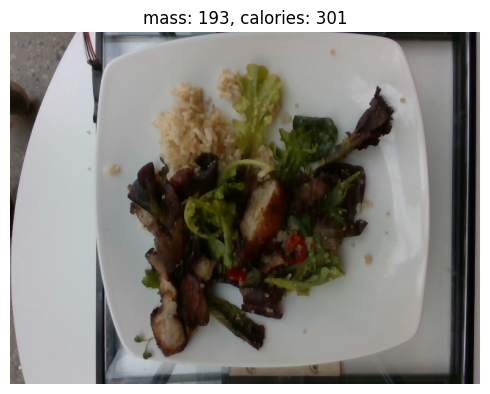

ingridients:  tensor([164,  67,  21, 179,  59,  19,  87,  45,  24, 117, 109, 175,  80, 152,
        180, 113, 168])


In [ ]:
transforms = get_transforms(cfg)
ds = MultimodalDataset(cfg, transforms, ds_type="test", initial_img=True)
item = ds[0]
initial_image = item["initial_image"]

plt.figure(figsize=(5, 5)) 

plt.imshow(initial_image)
plt.title(f'mass: {item["initital_mass"]:.0f}, calories: {item["label"]:.0f}')
plt.axis('off')
plt.tight_layout()
plt.show()
print("ingridients: ", item["ingr_idxs"])
# del ds

In [ ]:
train_loss_stat, val_loss_stat, train_mae_stat, val_mae_stat = train(cfg, device)

params to train: 359,265


  val epoch 1  : 100%|██████████| 8/8 [00:08<00:00,  1.02s/it, last batch loss=3549.3, last batch mae=132.5]


total epoch 1   train loss 6119.1, val loss 4787.9 train mae 218.3, val mae 173.7
----------------------------------------
New best model, epoch: 1
----------------------------------------


  val epoch 2  : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=2506.0, last batch mae=97.2] 


total epoch 2   train loss 3966.1, val loss 3770.3 train mae 146.4, val mae 139.6
----------------------------------------
New best model, epoch: 2
----------------------------------------


  val epoch 3  : 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, last batch loss=2170.4, last batch mae=86.3] 


total epoch 3   train loss 3197.7, val loss 3210.0 train mae 120.5, val mae 120.9
----------------------------------------
New best model, epoch: 3
----------------------------------------


  val epoch 4  : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=2170.6, last batch mae=86.4] 


total epoch 4   train loss 2788.7, val loss 2851.6 train mae 106.7, val mae 109.0
----------------------------------------
New best model, epoch: 4
----------------------------------------


train epoch 5  :  16%|█▌        | 7/44 [00:07<00:39,  1.06s/it, last batch loss=2906.2, last batch mae=110.4]

In [ ]:
check_inference(cfg, device)